In [1]:
%config Completer.use_jedi = False
import sys, os
sys.path.append('../pyecog2')
sys.path.append('../')
from ProjectClass import Project,FileBuffer,MainModel
# from pyecog2.main import MainModel
import json
import feature_extractor 
import importlib
importlib.reload(feature_extractor)
FeatureExtractor = feature_extractor.FeatureExtractor

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import spectrotools as spec
importlib.reload(spec)
from numba import jit, njit
import timeit

from scipy import stats
import json


In [2]:
import colorsys

In [3]:
import pyqtgraph as pg

In [4]:
from scipy.signal import get_window
import classifier
from scipy import linalg

In [5]:
main_model = MainModel()
project=Project(main_model=main_model)
project.load_from_json('/media/mfpleite/LaCie_1/ML_pyecog_2/ClassifierCVProject.pyecog')
fe = FeatureExtractor()

[]
copy from - history reset
[]
copy from - history reset
[]
copy from - history reset
[]
copy from - history reset
looking for 35
[]
copy from - history reset
['seizure(ELE)', 'repetitive 4IEDs', 'seizure', '(auto)seizure']
copy from - history reset
current animal: 35


In [6]:
project.project_file

'/media/mfpleite/LaCie_1/ML_pyecog_2/ClassifierCVProject.pyecog'

In [7]:
annotation0 = project.current_animal.annotations.annotations_list[1]
it = project.current_animal.eeg_init_time
index = [i  for i in range(len(it)) if (0<(annotation0.getStart()-it[i])<3600) ][0]
# index=0
fname = '.'.join(project.current_animal.eeg_files[index].split('.')[:-1]+['features'])
# fname ='/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1566408624_2019-08-21-18-30-24_tids_[119].features'

f_vec = np.fromfile(fname,dtype='float64')

fmeta_file = '.'.join(project.current_animal.eeg_files[index].split('.')[:-1] + ['fmeta'])
fmeta_dict = json.load(open(fmeta_file))


In [11]:
f_vec = f_vec.reshape((-1,fe.number_of_features))
f_vec[np.where(np.isnan(f_vec))] = 0

In [12]:
starts = [(annotation0.getStart()-it[index])/2.5 for annotation0 in project.current_animal.annotations.annotations_list]
ends = [(annotation0.getEnd()-it[index])/2.5 for annotation0 in project.current_animal.annotations.annotations_list]

f_labels = np.zeros(len(f_vec),dtype='bool')
for i in range(len(starts)-1) :
    s = int(np.floor(starts[i+1]))
    e = int(np.ceil(ends[i+1]))
    f_labels[s:e] = 1
    
f_vec_d  = np.hstack([f_vec,np.vstack([np.zeros(f_vec.shape[1]),np.diff(f_vec,axis=0)])])
f_vec_d  = f_vec
f_vec_d = f_vec_d-np.mean(f_vec_d,axis=0)
f_vec_d = f_vec_d/np.std(f_vec_d,axis = 0)

blanks = f_vec_d#[(1-f_labels).nonzero()[0],:]
seizures = f_vec_d[(f_labels).nonzero()[0],:]

blanks_mu  = blanks.mean(axis=0)
blanks_cov = (blanks-blanks_mu).T.dot((blanks-blanks_mu))/blanks.shape[0]
seizures_mu  = seizures.mean(axis=0)
seizures_cov = (seizures-seizures_mu).T.dot((seizures-seizures_mu))/seizures.shape[0]

[Text(0, 0, 'min'),
 Text(0, -1, 'max'),
 Text(0, -2, 'mean'),
 Text(0, -3, 'log std'),
 Text(0, -4, 'kurtosis'),
 Text(0, -5, 'skewness'),
 Text(0, -6, 'log coastline (log sum of abs diff)'),
 Text(0, -7, 'log power in band (1, 4) Hz'),
 Text(0, -8, 'log power in band (4, 8) Hz'),
 Text(0, -9, 'log power in band (8, 12) Hz'),
 Text(0, -10, 'log power in band (12, 30) Hz'),
 Text(0, -11, 'log power in band (30, 50) Hz'),
 Text(0, -12, 'log power in band (50, 70) Hz'),
 Text(0, -13, 'log power in band (70, 120) Hz'),
 Text(0, -14, 'Spectrum entropy')]

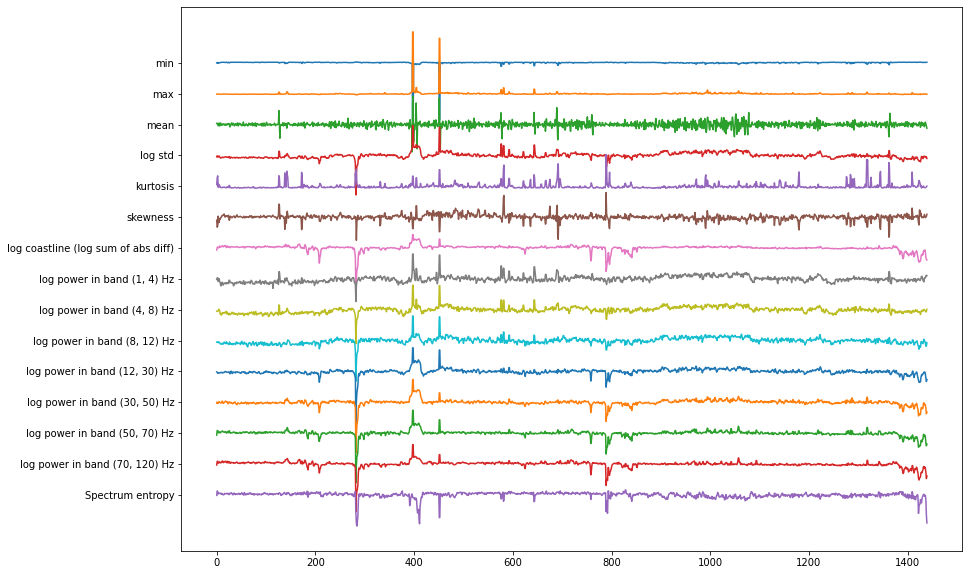

In [13]:

f = plt.figure(figsize=(14,10))
ax = f.gca()
spec.plot_spread(f_vec_d,.5);

# plt.xlim([400,1000])
# plt.vlines(starts[1:],-15,0)
# plt.vlines(ends[1:],-15,0)
ax.set_yticks(range(0,-fe.number_of_features,-1))
ax.set_yticklabels(fe.settings['feature_labels'])

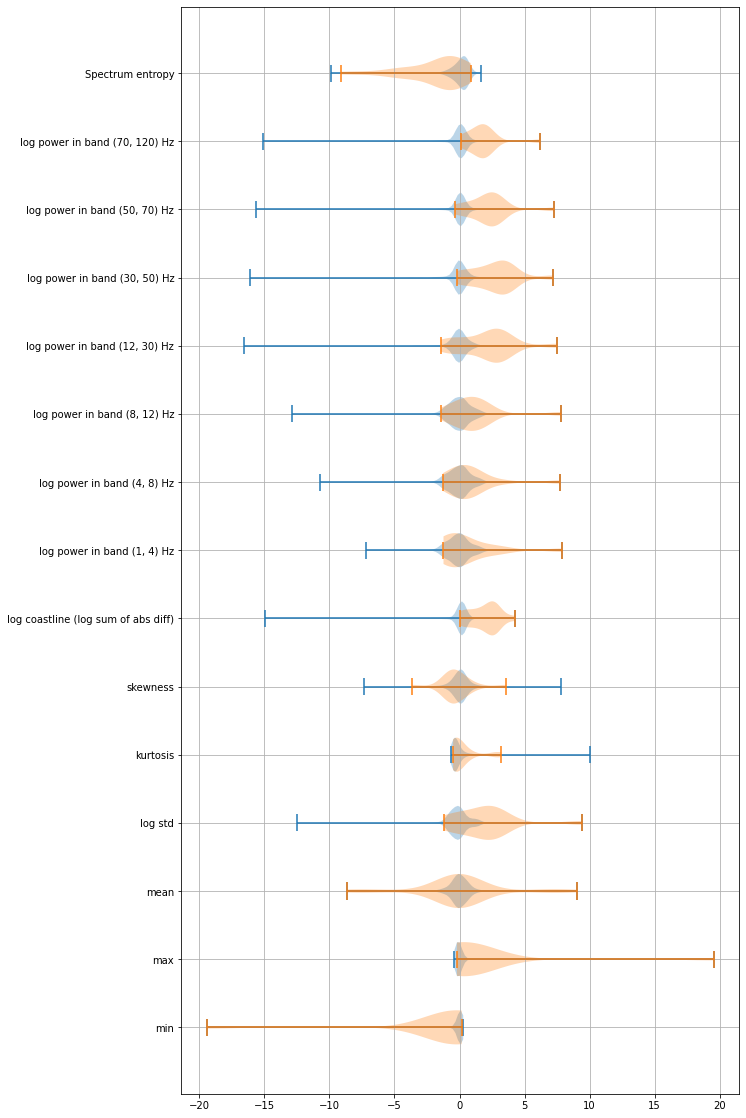

In [14]:
plt.figure(figsize=(10,20))
plt.violinplot(blanks,vert=False);
plt.violinplot(seizures,vert=False);
ax=plt.gca()
# ax.set_yticks(list(range(1,fe.number_of_features+1,1)) + 
#               list(range(fe.number_of_features+1,2*fe.number_of_features+1,1)))
# ax.set_yticklabels(fe.settings['feature_labels'] + ['d'+s+'/dt' for s in fe.settings['feature_labels']])
ax.set_yticks(list(range(1,fe.number_of_features+1,1)))
ax.set_yticklabels(fe.settings['feature_labels'])
plt.grid()

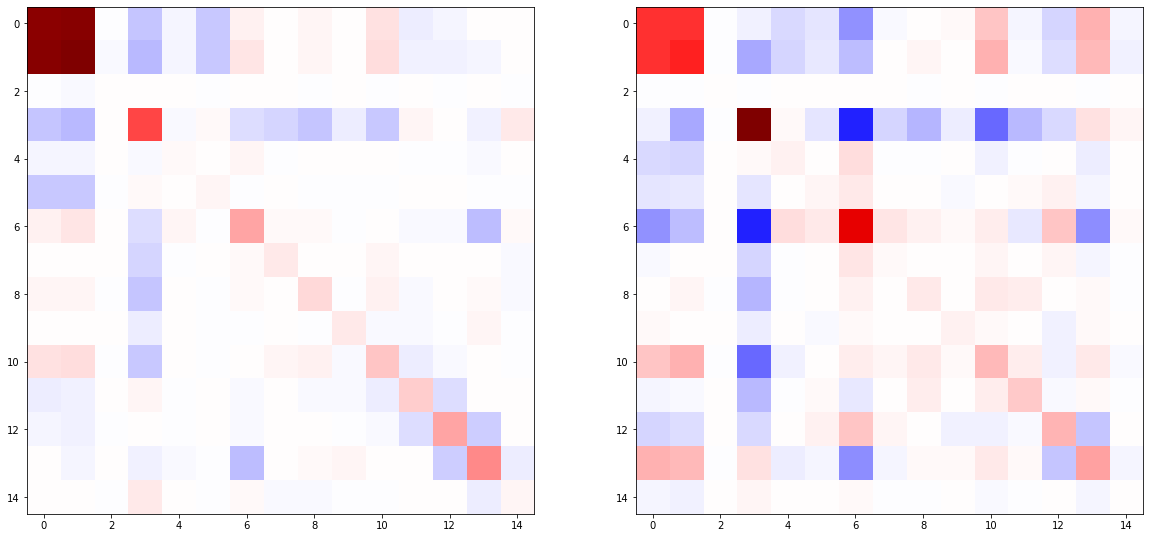

In [15]:
blanks_cov_i = np.linalg.inv(blanks_cov)
seizures_cov_i = np.linalg.inv(seizures_cov)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(blanks_cov_i,cmap='seismic',vmin=-np.max(np.abs(blanks_cov_i)),vmax=np.max(np.abs(blanks_cov_i)))
plt.subplot(1,2,2)
plt.imshow(seizures_cov_i,cmap='seismic',vmin=-np.max(np.abs(seizures_cov_i)),vmax=np.max(np.abs(seizures_cov_i)))

In [16]:
fe.settings['feature_labels']

['min',
 'max',
 'mean',
 'log std',
 'kurtosis',
 'skewness',
 'log coastline (log sum of abs diff)',
 'log power in band (1, 4) Hz',
 'log power in band (4, 8) Hz',
 'log power in band (8, 12) Hz',
 'log power in band (12, 30) Hz',
 'log power in band (30, 50) Hz',
 'log power in band (50, 70) Hz',
 'log power in band (70, 120) Hz',
 'Spectrum entropy']

In [17]:
@jit(nopython=True)
def MVGD_LL_jit(fdata,mu,inv_cov,LL,no_scale):
    k = fdata.shape[1]
    N = fdata.shape[0]
    scale = (1-no_scale)*((-k/2)*np.log(2*np.pi)+1/2*np.log(np.linalg.det(inv_cov[:,:])))
    for i in range(N):
        LL[i] = scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T)

def MVGD_LL(fdata,mu,inv_cov,no_scale = False):
    LL = np.zeros(fdata.shape[0])
    MVGD_LL_jit(fdata,mu,inv_cov,LL, no_scale)
    return LL

@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

<ipython-input-17-da9e4bc747e3>:7: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  LL[i] = scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T)
/home/mfpleite/anaconda3/envs/pyecog2/lib/python3.8/site-packages/numba-0.52.0-py3.8-linux-x86_64.egg/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


(-500.0, 400.0)

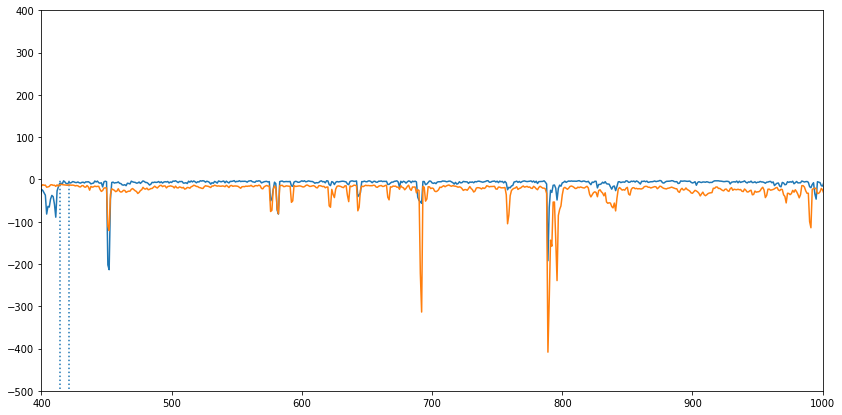

In [18]:
blanks_cov_i = np.linalg.inv(blanks_cov)
blanks_cov_ir = np.linalg.inv(blanks_cov+np.eye(len(blanks_cov))*blanks_cov.diagonal()/len(blanks))

seizures_cov_i = np.linalg.inv(seizures_cov)
seizures_cov_ir = np.linalg.inv(seizures_cov+np.eye(len(seizures_cov))*seizures_cov.diagonal()/len(seizures))

b_LL = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_i)
s_LL = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_i)
b_LLr = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_ir)
s_LLr = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_ir)

plt.figure(figsize=(14,7))
# plt.plot(b_LL)
plt.plot(b_LLr)
# plt.plot(s_LL)
plt.plot(s_LLr)
plt.vlines(starts[1:],-2000,0,linestyles=':')
plt.vlines(ends[1:],-2000,0,linestyles=':')

plt.xlim(400,1000)
plt.ylim(-500,400)

(400.0, 1000.0)

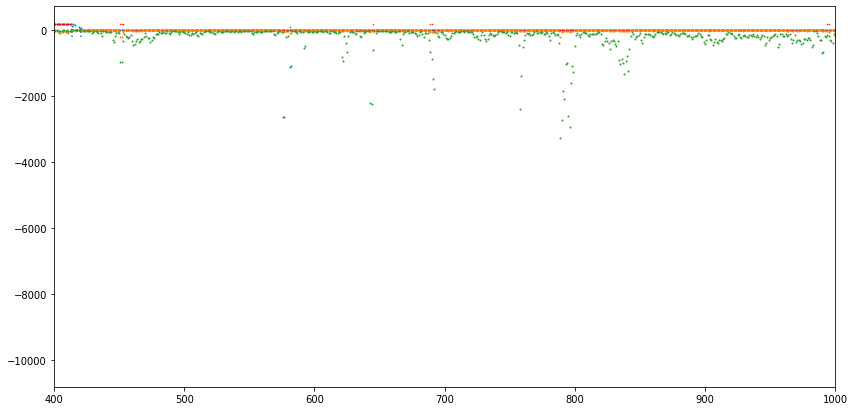

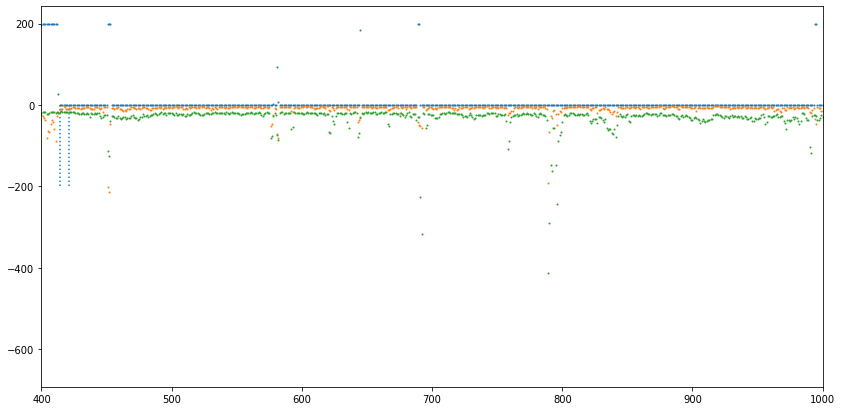

In [19]:
blanks_LL = MVGD_LL(blanks,blanks_mu,blanks_cov_i,no_scale=True)
seizures_LL = MVGD_LL(seizures,seizures_mu,seizures_cov_i,no_scale=True)

blank_bias = np.log(len(blanks)/(len(blanks)+len(seizures)))
seizure_bias = np.log(len(seizures)/(len(blanks)+len(seizures)))


b_LL = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_i)+ blank_bias
s_LL = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_i)+ seizure_bias
b_LLr = MVGD_LL(f_vec_d,blanks_mu,blanks_cov_ir) + blank_bias
s_LLr = MVGD_LL(f_vec_d,seizures_mu,seizures_cov_ir) + seizure_bias

LL = np.array([b_LL.T,s_LL.T]).T
p  = LL2prob(LL) 

LLr = np.array([b_LLr.T,s_LLr.T]).T
pr  = LL2prob(LLr) 

plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(pr[:,1]*200,'.',markersize=1,color = [1,0,0,1])
plt.plot(b_LL,'.',markersize=2)
plt.plot(s_LL,'.',markersize=2)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')
plt.xlim(400,1000)

plt.figure(figsize=(14,7))
plt.plot(pr[:,1]*200,'.',markersize=2)
plt.plot(b_LLr,'.',markersize=2)
plt.plot(s_LLr,'.',markersize=2)
plt.vlines(starts[1:],-200,0,linestyles=':')
plt.vlines(ends[1:],-200,0,linestyles=':')
plt.xlim(400,1000)

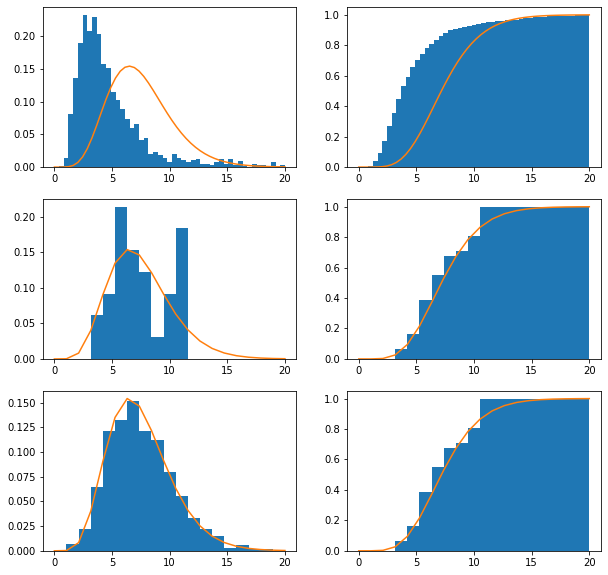

In [20]:
plt.figure(figsize=(10,10))
dof = f_vec.shape[1]
x = np.linspace(0,20,50)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
plt.subplot(321)
plt.hist(-blanks_LL,bins = x,density = True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(322)
plt.hist(-blanks_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)

x = np.linspace(0,20,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(323)
plt.hist(-seizures_LL,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(324)
plt.hist(-seizures_LL,bins = x,density=True,cumulative=True);
plt.plot(x,cum_chi2)


f_rand = np.random.randn(*f_vec.shape)
LL_rand = 0.5*np.sum(f_rand**2,axis = 1)
x = np.linspace(0,20,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(325)
plt.hist(LL_rand,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(326)
plt.hist(-seizures_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)





In [8]:
import classifier
from scipy import linalg

importlib.reload(classifier)

<module 'classifier' from '../pyecog2/classifier.py'>

In [9]:
PGC = classifier.ProjectClassifier(project=project)

loading /media/mfpleite/LaCie_1/ML_pyecog_2/ClassifierCVProject.pyecog_classifier
Could not load imported classifier
Could not load feature extractor


In [10]:
print(PGC.global_classifier.class_npoints,PGC.global_classifier.blank_npoints)

[ 1982 18576] 32029984


In [11]:
print(PGC.imported_classifier.class_npoints,PGC.imported_classifier.blank_npoints)

[0 0 0] 0


In [12]:
PGC.assimilate_global_classifier()

assimilating 119
assimilating 120
assimilating 141
assimilating 17
assimilating 28
assimilating 33
assimilating 35


In [13]:
GC = classifier.GaussianClassifier(project,fe)
GC.copy_from(PGC.animal_classifier_dict['119'])
GC.labels2classify

KeyError: 'overlap'

In [41]:
for k,c in PGC.animal_classifier_dict.items():
    _,_,npts = c.all_mu_and_cov()
    print(k,npts)

119 4921480
120 4870354
141 2742595
17 4956225
28 4867696
33 4864816
35 4827376


In [28]:
GC = classifier.GaussianClassifier(project,fe)
GC.copy_re_normalized_classifier(PGC.global_classifier)

In [29]:
GC.all_mu_and_cov()[2] - PGC.animal_classifier_dict['119'].all_mu_and_cov()[2]

27129062

In [30]:
GC = classifier.GaussianClassifier(project,fe,['seizure','repeated IIEDs'])
GC2 = classifier.GaussianClassifier(project,fe,['seizure','repeated IIEDs'])
GC3 = classifier.GaussianClassifier(project,fe,['seizure','repeated IIEDs'])

In [31]:
project.current_animal.annotations.labels

['seizure(ELE)', 'seizure', 'repetitive 4IEDs', '(auto)seizure']

In [73]:
GC = classifier.GaussianClassifier(project,fe)

In [25]:
GC.train(project.animal_list[:1])

Training with animal: h5_119
Training with classes: ['seizure' 'repeated IIEDs']
Transitions:19 file: 1709 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1572561642_2019-10-31-22-40-42_tids_[119].featuresfile: 417 of 1710 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_119/M1567907359_2019-09-08-02-49-19_tids_[119].features
 [[ 0. 11. 39.]
 [11.  0.  0.]
 [39.  0.  1.]]


In [26]:
GC2.train(project.animal_list[1:2])

Training with animal: h5_120
Training with classes: ['seizure' 'repeated IIEDs']
Transitions:20 file: 1691 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1572561642_2019-10-31-22-40-42_tids_[120].features92 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1567164624_2019-08-30-12-30-24_tids_[120].features file: 521 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1568350159_2019-09-13-05-49-19_tids_[120].featuresfile: 741 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1569142159_2019-09-22-09-49-19_tids_[120].featuresfile: 1021 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1570150159_2019-10-04-01-49-19_tids_[120].features1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1570938559_2019-10-13-04-49-19_tids_[120].featuresfile: 1359 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1571366959_2019-10-18-03-49-19_tids_[120].featuresh5_120 file: 1525 of 1692 /media/mfple

In [26]:
GC3.train(project.animal_list[1:2])

Training with animal: h5_120
Training with classes: ['seizure' 'repeated IIEDs']
Transitions:20 file: 1691 of 1692 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_120/M1572561642_2019-10-31-22-40-42_tids_[120].features
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [27]:
GC2.copy_re_normalized_classifier(GC)

In [28]:
mu3,W3,iW3 = GC3.whitening_mu_W_iW()
mu2,W2,iW2 = GC2.whitening_mu_W_iW()
mu,W,iW = GC.whitening_mu_W_iW()

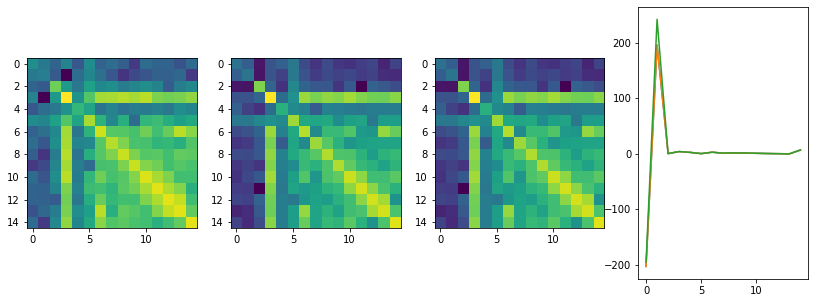

In [29]:
plt.figure(figsize=(14,5))
plt.subplot(1,4,1)
plt.imshow(np.log(np.abs(W)))
plt.subplot(1,4,2)
plt.imshow(np.log(np.abs(W2)))
plt.subplot(1,4,3)
plt.imshow(np.log(np.abs(W3)))
plt.subplot(1,4,4)
plt.plot(mu3)
plt.plot(mu2)
plt.plot(mu)

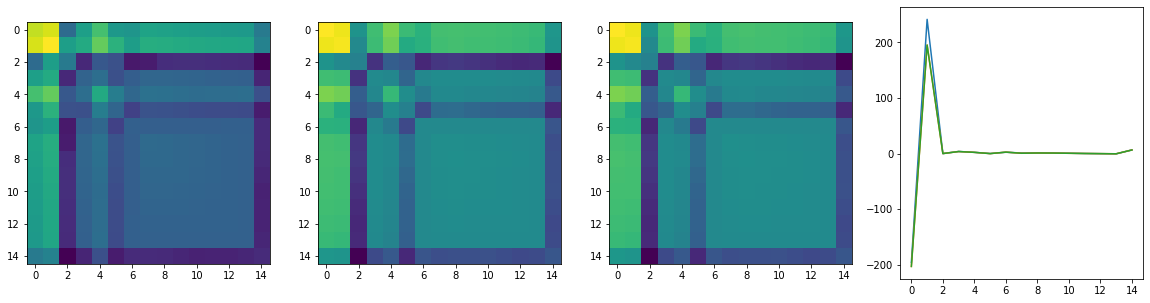

In [30]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.subplot(1,4,2)
plt.imshow(np.log(np.abs(GC2.blank_cov)))
plt.subplot(1,4,3)
plt.imshow(np.log(np.abs(GC3.blank_cov)))
plt.subplot(1,4,4)
plt.plot(GC.blank_means)
plt.plot(GC2.blank_means)
plt.plot(GC3.blank_means)

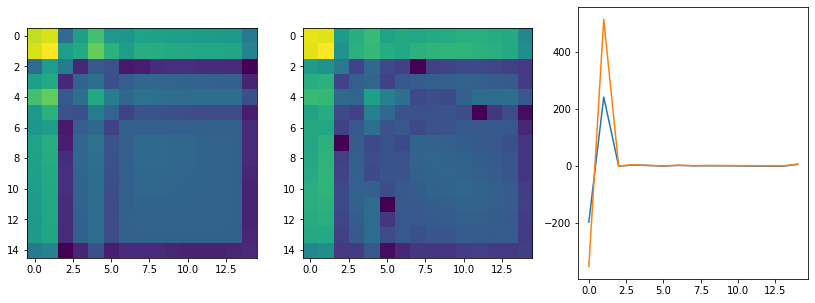

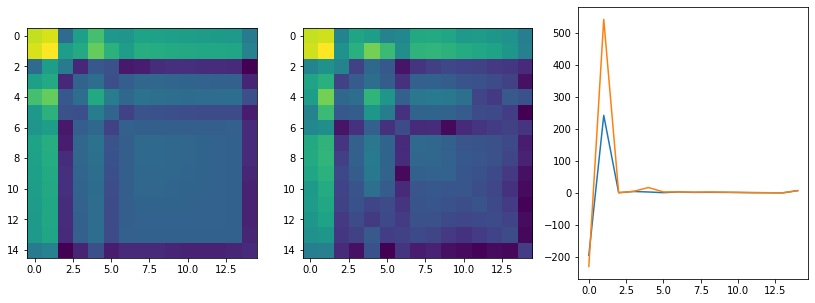

In [31]:
mu = GC.blank_means[:,np.newaxis]
cov = GC.blank_cov
npoints = GC.blank_npoints
for i in range(len(GC.labels2classify)):
    muc = GC.class_means[i][:,np.newaxis]
    covc = GC.class_cov[i]
    npointsc = GC.class_npoints[i]
    plt.figure(figsize=(14,5))
    plt.subplot(1,3,1)
    plt.imshow(np.log(np.abs(cov)))
    plt.subplot(1,3,2)
    plt.imshow(np.log(np.abs(covc)))
    plt.subplot(1,3,3)
    plt.plot(mu)
    plt.plot(muc)
    mu,cov = classifier.average_mu_and_cov(mu,cov,npoints,muc,covc,npointsc)
    npoints += npointsc

In [32]:
npoints

4922138

In [33]:
GC.blank_npoints

4919576

In [34]:
GC.class_means

array([[-3.51423919e+02,  5.13779225e+02,  1.80570806e-03,
         4.69156231e+00,  2.00169265e+00,  6.85473763e-01,
         3.24363660e+00,  1.42822727e+00,  2.00751396e+00,
         1.79039369e+00,  1.51050439e+00,  1.32233453e+00,
         1.04094879e+00,  5.89191443e-01,  6.26568352e+00],
       [-2.30474727e+02,  5.41701138e+02,  7.51830549e-03,
         4.24010831e+00,  1.61132161e+01,  2.37871420e+00,
         2.43018066e+00,  1.71032252e+00,  2.12867280e+00,
         1.64366436e+00,  9.81190247e-01,  3.10202299e-01,
        -3.23120963e-02, -3.94742712e-01,  6.51770913e+00]])

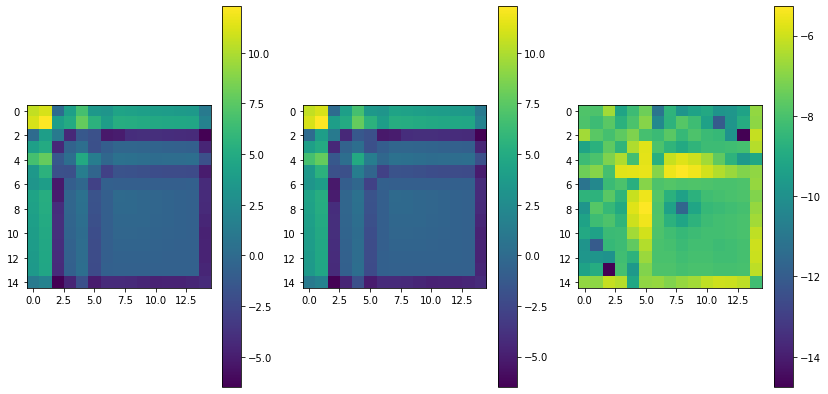

In [35]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(np.log(np.abs(cov)))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(GC.blank_cov-cov))-np.log(np.abs(GC.blank_cov)))
# plt.imshow(np.log(np.abs(A)))
plt.colorbar()

In [36]:
A = linalg.sqrtm(classifier.reg_invcov(GC.blank_cov,GC.blank_npoints))

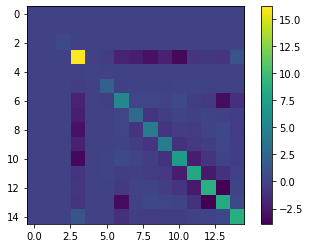

In [37]:
plt.imshow(A)
plt.colorbar()

In [38]:
error = A@GC.blank_cov@A.T - np.eye(GC.Ndim)

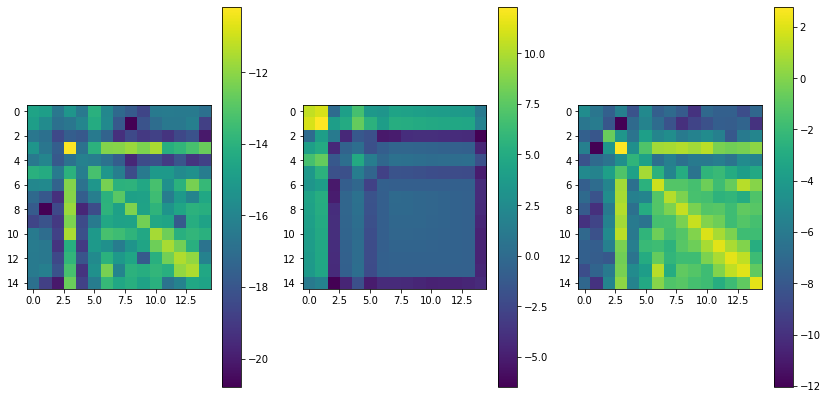

In [39]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(np.log(np.abs(error)))
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(A)))
plt.colorbar()


In [40]:
# GC2._debug_f_vec_d.shape

In [41]:
# f = plt.figure(figsize=(14,10))
# ax = f.gca()
# spec.plot_spread(GC2._debug_f_vec_d[:,-4:],.5);

In [45]:
import spectrotools as spec

(-5.0, 8.0)

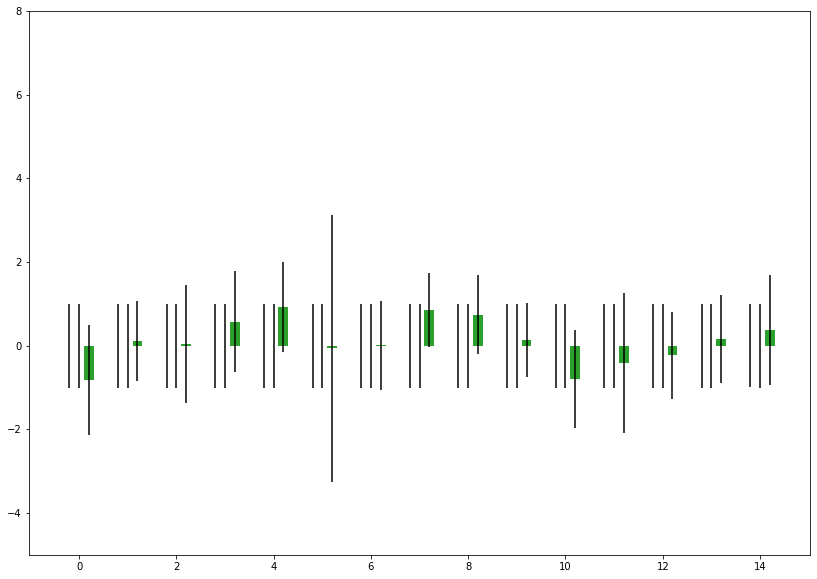

In [53]:
plt.figure(figsize=(14,10))
blank_std = np.sqrt(np.diag(GC.blank_cov))
class_std0 = np.sqrt(np.diag(GC.class_cov[0]))
class_std1 = np.sqrt(np.diag(GC.class_cov[1]))
# plt.plot(GC.blank_means[:],'k')
# plt.plot(GC.blank_means[:]+blank_std,'k:')
# plt.plot(GC.blank_means[:]-blank_std,'k:')
# plt.ylim([-10,10])
# plt.plot(GC.class_means[0,:],'b')
# plt.plot(GC2.class_means[0,:],'b:')
plt.bar(np.arange(GC.Ndim)-.2,GC.blank_means[:],yerr=blank_std,width=.2)
plt.bar(np.arange(GC.Ndim),GC.class_means[0,:],yerr=class_std0,width=.2)
plt.bar(np.arange(GC.Ndim)+.2,GC.class_means[1,:],yerr=class_std1,width=.2)
plt.ylim([-5,8])

NameError: name 'GC2' is not defined

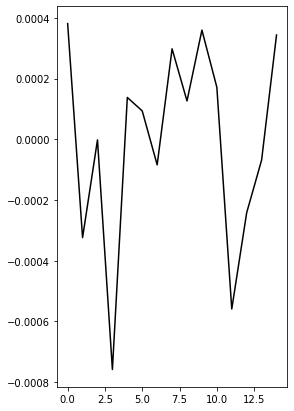

In [54]:
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.plot(GC.blank_means,'k')
plt.plot(GC2.blank_means,'k:')
plt.plot(GC.class_means[0,:],'b')
plt.plot(GC2.class_means[0,:],'b:')
plt.subplot(1,3,2)
plt.imshow(np.log(np.abs(GC.blank_cov)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(GC2.blank_cov)))
plt.colorbar()


In [31]:
project.animal_list[1].id

'120'

In [32]:
PGC = classifier.ProjectClassifier(project=project)
PGC.assimilate_global_classifier(labels2train=['repetitive 4IEDs', 'seizure'])
GC = classifier.GaussianClassifier(project,fe)
GC.copy_from(PGC.animal_classifier_dict[project.current_animal.id])

loading /media/mfpleite/LaCie_1/ML_pyecog_2/ClassifierCVProject.pyecog_classifier
Could not load imported classifier
Could not load feature extractor
assimilating 119
assimilating 120
assimilating 141
assimilating 17
assimilating 28
assimilating 33
assimilating 35


In [33]:
GC.copy_re_normalized_classifier(PGC.global_classifier)

In [34]:
PGC.global_classifier.transitions_matrix

array([[  0.,  20., 644.],
       [ 20.,   0.,   0.],
       [644.,   0.,   3.]])

In [35]:
GC.transitions_matrix

array([[  0.,  20., 644.],
       [ 20.,   0.,   0.],
       [644.,   0.,   3.]])

In [36]:
PGC.global_classifier.labels2classify

array(['repetitive 4IEDs', 'seizure'], dtype='<U16')

In [37]:
(LLv,R2v,pf,timev) = GC.classify_animal(project.current_animal,max_annotations=100)

../pyecog2/classifier.py:25: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  LL[i] =( scale - 0.5*(fdata[i,:]-mu)@(inv_cov[:,:] @(fdata[i,:]-mu).T))[0,0]  # the [0,0] is for numba wizzardry to work
/home/mfpleite/anaconda3/envs/pyecog2/lib/python3.8/site-packages/numba-0.52.0-py3.8-linux-x86_64.egg/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, F))
  warnings.warn(NumbaPerformanceWarning(msg))


Animal: 35 file: 1676 of 1677 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_35/M1573558842_2019-11-12-11-40-42_tids_[35].fmeta/media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_35/M1567903759_2019-09-08-01-49-19_tids_[35].fmeta 35 file: 203 of 1677 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_35/M1568252959_2019-09-12-02-49-19_tids_[35].fmeta 35 file: 296 of 1677 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_35/M1568587759_2019-09-15-23-49-19_tids_[35].fmeta35 file: 432 of 1677 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_35/M1569077359_2019-09-21-15-49-19_tids_[35].fmeta 35 file: 514 of 1677 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_35/M1569372559_2019-09-25-01-49-19_tids_[35].fmeta 35 file: 581 of 1677 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_35/M1569617359_2019-09-27-21-49-19_tids_[35].fmeta 35 file: 983 of 1677 /media/mfpleite/LaCie_1/ML_pyecog_2/data_from_ele/h5_35/M1571064559_2019-10-14-15-49-19_tids_[35].fmeta 35 file: 1430 

In [38]:
# (LLv,R2v,pf,timev) = GC2.classify_animal(project.animal_list[1],max_annotations=100)

In [39]:
# project.save_to_json(fname = project.project_file[:-7]+'_test.pyecog')

<ipython-input-45-596b07b7e259>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(1-pf.T),'.', markersize=.1)


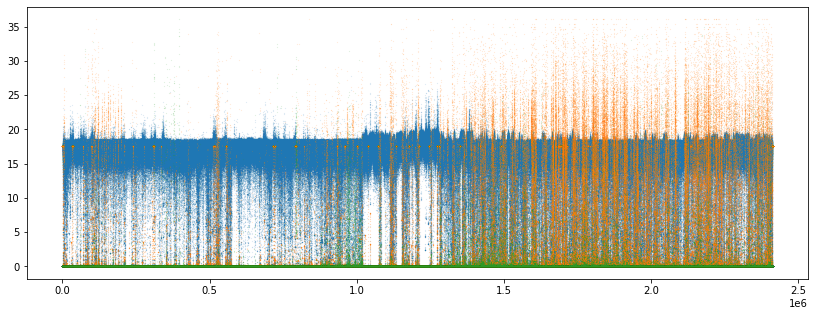

In [45]:
plt.figure(figsize=(14,5))
plt.plot(-np.log(1-pf.T),'.', markersize=.1)
# plt.ylim(-100,50)

In [46]:
 _, _, total_npoints = GC.all_mu_and_cov()
th = stats.chi2.isf(1/total_npoints,GC.Ndim,scale=0.5)
print(1/total_npoints,th)

3.120072041215403e-08 32.61257328131159


In [47]:
GC.labels2classify

array(['repetitive 4IEDs', 'seizure'], dtype='<U16')

In [119]:
starts = np.array([a.getStart() for a in project.current_animal.annotations.annotations_list if a.getLabel() =='seizure(ELE)'])
ends = np.array([a.getEnd() for a in project.current_animal.annotations.annotations_list if a.getLabel() =='seizure(ELE)'])

In [52]:
starts

array([1.56767056e+09, 1.56772000e+09, 1.56778561e+09, 1.56830020e+09,
       1.56836425e+09, 1.56838359e+09, 1.56839000e+09, 1.56839708e+09,
       1.56840034e+09, 1.56840553e+09, 1.56840893e+09, 1.56842718e+09,
       1.56844785e+09, 1.56846037e+09, 1.56847036e+09, 1.56847250e+09,
       1.56847256e+09, 1.56847369e+09, 1.56847560e+09, 1.56851249e+09,
       1.56851593e+09, 1.56851832e+09, 1.56915702e+09, 1.56935063e+09,
       1.57078214e+09, 1.57131917e+09, 1.57159590e+09, 1.57205607e+09,
       1.57207425e+09, 1.57219055e+09, 1.57219661e+09, 1.57224920e+09,
       1.57234568e+09, 1.57236060e+09, 1.57245486e+09, 1.57256876e+09,
       1.57261600e+09, 1.57262337e+09, 1.57268514e+09])

0.5

In [148]:
import numpy as np
_, _, total_npoints = GC.all_mu_and_cov()
th = stats.chi2.isf(1/total_npoints,GC.Ndim,scale=0.5)
LLth = np.diag(GC.log_likelyhoods(np.vstack((GC.blank_means, GC.class_means)), bias=False)) - th
LLv_reg = np.maximum(LLth, LLv)*(1-self.overlap)
# LLv_reg = LLv_reg*(1-fe.settings['overlap'])

from hmm_pyecog import HMM_LL
from classifier import transitions2rates
hmm = HMM_LL()
hmm.A = transitions2rates(GC.transitions_matrix, GC.blank_npoints, GC.class_npoints)

# pf = hmm.forward_backward(LLv.T)
hmm.forward_backward(LLv_reg.T)

HMM:forward
HMM:backward


array([[1.42910161e-02, 8.42622526e-03, 4.96824735e-03, ...,
        4.96824735e-03, 8.42622532e-03, 1.42910161e-02],
       [9.85708981e-01, 9.91573775e-01, 9.95031753e-01, ...,
        9.95031753e-01, 9.91573775e-01, 9.85708981e-01],
       [2.92175282e-09, 8.81350911e-11, 3.60772116e-11, ...,
        3.60772119e-11, 8.81350911e-11, 2.92175284e-09]])

In [149]:
GC.transitions_matrix

array([[  0.,  20., 644.],
       [ 20.,   0.,   0.],
       [644.,   0.,   3.]])

In [150]:
ab = (hmm.alpha + hmm.beta).T
ab = ab-ab.max(axis=1,keepdims=True)
log_not_posterior = np.log(np.exp(ab)@(np.ones((ab.shape[1],ab.shape[1])) - np.eye(ab.shape[1]))) \
                    - np.log(np.exp(ab)@(np.ones((ab.shape[1],ab.shape[1]))))

In [151]:
len(log_not_posterior.ravel()) - np.sum(np.isfinite(log_not_posterior))

0

In [152]:
log_not_posterior[~np.isfinite(log_not_posterior)]= -1000

In [153]:
k = np.where(GC.labels2classify == 'seizure')[0]+1

<IPython.core.display.Javascript object>


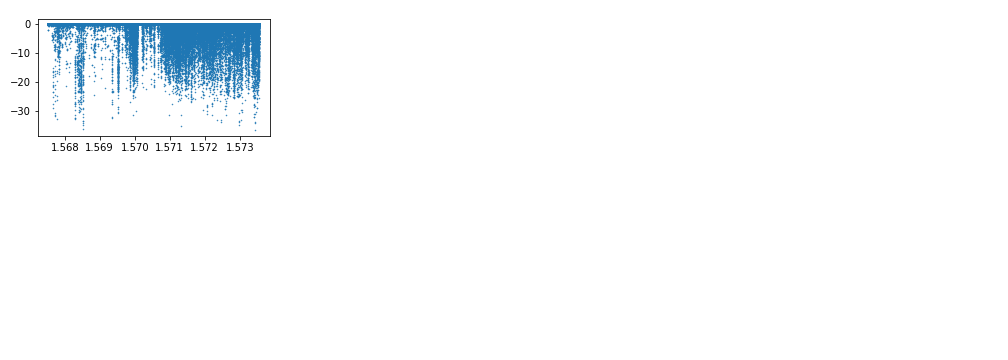

In [154]:
%matplotlib notebook
plt.figure(figsize=(14,5))
plt.plot(timev,log_not_posterior[:,k],'.', markersize=1,alpha=1)
# plt.ylim(-70,10)
# plt.legend()

for s,e in zip(starts,ends):
    indices = np.array((timev>s)*(timev<e)).astype('bool')
    lps = log_not_posterior[indices,k]
    plt.plot(timev[indices],lps,'r.',markersize=2)

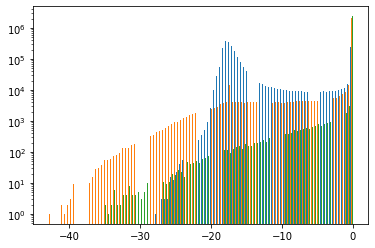

In [155]:
%matplotlib inline
plt.hist(log_not_posterior,bins=100,log=True);

In [156]:
from annotations_module import AnnotationElement
from classifier import intervals_overlap

self = GC
animal = project.current_animal
max_annotations = 100000
labels2annotate = ['seizure']

for i2,label in enumerate(self.labels2classify):
    if label not in labels2annotate: # ignore labels that are not in labels2annotate
        continue
    i = i2+1
    print(i,label)
    starts = np.nonzero(np.diff(((pf[i, :].T * (-R2v[:, i] < th)) > .5).astype('int')) > 0)[0] + 1
    ends = np.nonzero(np.diff(((pf[i, :].T * (-R2v[:, i] < th)) > .5).astype('int')) < 0)[0] + 1
    alist = []
    print('len starts',len(starts))
    manual_label_positions = [a.getPos() for a in animal.annotations.get_all_with_label(label)]
    ELEmanual_label_positions = [a.getPos() for a in animal.annotations.get_all_with_label(label+'(ELE)')]
    ELEmanual_label_positions_c = - np.ones(len(ELEmanual_label_positions))*np.inf
    print('manual label positions:',manual_label_positions)
    for j in range(len(starts)):
        if not any([intervals_overlap([timev[starts[j]],timev[ends[j]]],pos) for pos in manual_label_positions]):
            if ends[j]-starts[j]<1:
                print('interval too small:',starts[j],ends[j])
                continue
            # c = np.sum(LLv[starts[j]:ends[j],i])-np.sum(LLv[starts[j]:ends[j],0])
            # c = np.sum(np.log(pf[i,starts[j]:ends[j]])-np.log(np.maximum(1-pf[i,starts[j]:ends[j]],1e-12)))
            # c = np.sum(-np.log(np.maximum(1-pf[i,starts[j]:ends[j]],1e-12)))
            # c = np.max(-np.log(np.maximum(1-pf[i,starts[j]:ends[j]],2**-50)))
            # c = np.max(LLv_reg[starts[j]:ends[j], i])
            # c = np.mean(R2v[starts[j]:ends[j], i])
            c = np.max( - log_not_posterior[starts[j]:ends[j], i])
            # print('start,end,confidence', starts[j], ends[j],c)
            a = AnnotationElement(label='(auto)'+label,start=timev[starts[j]],end=timev[ends[j]],confidence=c)
            o = any([intervals_overlap([timev[starts[j]],timev[ends[j]]],pos) for pos in ELEmanual_label_positions])
            if o:
                k = np.where([intervals_overlap([timev[starts[j]],timev[ends[j]]],pos) for pos in ELEmanual_label_positions])[0]
                ELEmanual_label_positions_c[k] = max(ELEmanual_label_positions_c[k],c)
            alist.append((c,o,a))
        else:
            print('annotation already exists at', starts[j], ends[j])

    print('Found',len(alist), 'putative events. Saving',max_annotations,'withh highest confidence score')
    alist.sort(key=lambda c:-c[0])
#     animal.annotations.delete_label('(auto)'+label)  # Delete all previous auto generated labels 
#     try:
#         old_color = animal.annotations.label_color_dict[label]
#         print('found color for ', label, old_color)
#     except Exception:
#         print('did not find color for' , label)
#         old_color = (255,255,255)
#     new_color = tuple([ max(int(c*0.65),0) for c in old_color])
#     animal.annotations.add_label('(auto)'+label,color = new_color)

#     animal.annotations.pause_history_cache(True)
#     for c,a in alist[:max_annotations]:
#         animal.annotations.add_annotation(a)
#     animal.annotations.pause_history_cache(False)

2 seizure
len starts 3604
manual label positions: []
Found 3604 putative events. Saving 100000 withh highest confidence score


In [146]:
cv,ov,av = zip(*alist)
FPR = np.cumsum(1-np.array(ov))/sum(ov)
TPR = np.array([sum(ELEmanual_label_positions_c>=c) for c in cv])/len(ELEmanual_label_positions_c)

In [157]:
cv2,ov2,av2 = zip(*alist)
FPR2 = np.cumsum(1-np.array(ov2))/sum(ov2)
TPR2 = np.array([sum(ELEmanual_label_positions_c>=c) for c in cv2])/len(ELEmanual_label_positions_c)

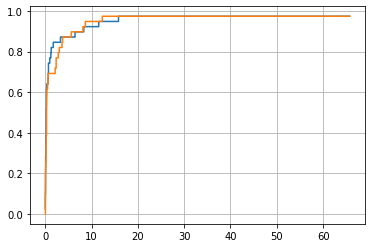

In [158]:
plt.plot(FPR,TPR)
plt.plot(FPR2,TPR2)
plt.grid(True)

<ipython-input-62-6d7d47433848>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(1-hmm.posterior[1:,:].T),'.', markersize=1,alpha=.1)


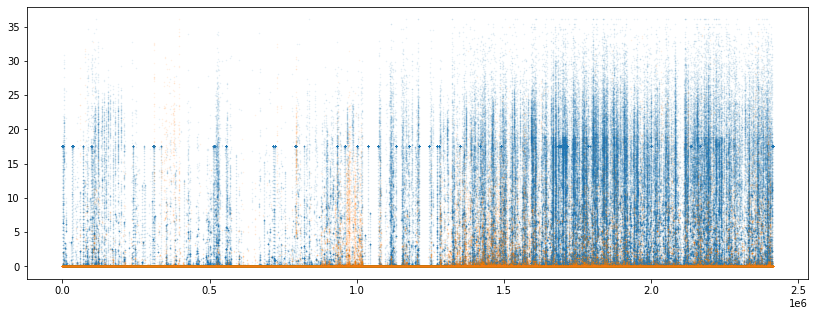

In [62]:
plt.figure(figsize=(14,5))
plt.plot(-np.log(1-hmm.posterior[1:,:].T),'.', markersize=1,alpha=.1)
# plt.ylim(-100,50)

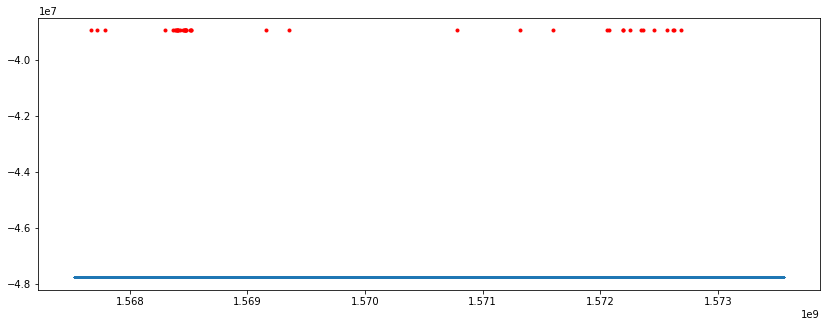

In [63]:
plt.figure(figsize=(14,5))
plt.plot(starts,starts*0-275-3.8947e7,'r.')
plt.plot(timev, hmm.alpha[1,:].T + hmm.beta[1,:].T,'.', markersize=1,alpha = .1)

In [44]:
GC.labels2classify

array(['seizure', 'repeated IIEDs'], dtype='<U14')

In [91]:
th = stats.chi2.isf(1e-3,GC.Ndim,scale=0.5)

In [92]:
th

18.848649109176915

In [112]:
len(R2v)

2461208

In [111]:
i=1
np.sum(((pf[i, :].T * (-R2v[:, i] < th)) > .5).astype('int'))/len(R2v)

0.005620817094694963

<IPython.core.display.Javascript object>


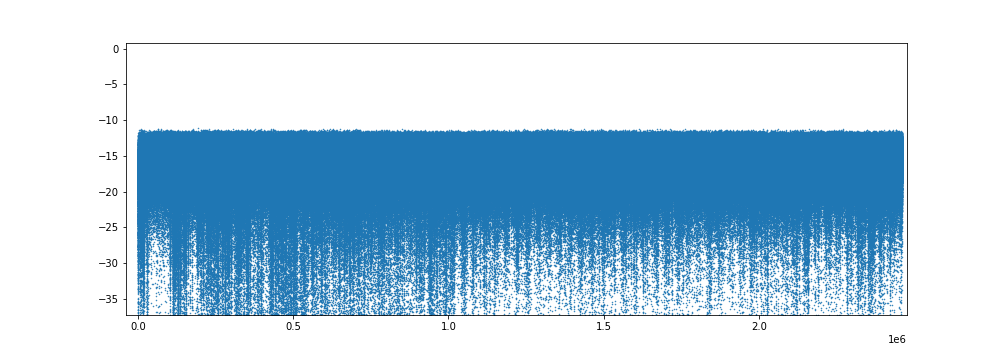

In [57]:
%matplotlib notebook
plt.figure(figsize=(14,5))
plt.plot(R2v[:,0],'.', markersize=1)

<IPython.core.display.Javascript object>


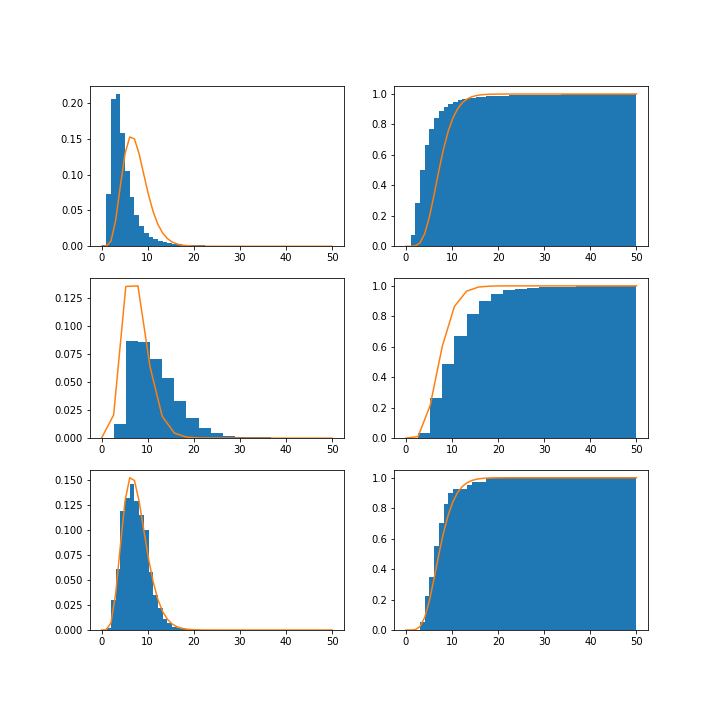

In [104]:
plt.figure(figsize=(10,10))
dof = GC.Ndim
x = np.linspace(0,50,50)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
plt.subplot(321)
plt.hist(-R2v[:,0],bins = x,density = True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(322)
plt.hist(-R2v[:,0],bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)


x = np.linspace(0,50,20)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(323)
plt.hist(-R2v[:,1],bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(324)
plt.hist(-R2v[:,1],bins = x,density=True,cumulative=True);
plt.plot(x,cum_chi2)


f_rand = np.random.randn(*f_vec.shape)
LL_rand = 0.5*np.sum(f_rand**2,axis = 1)
x = np.linspace(0,50,50)
chi2 = stats.chi2.pdf(x,dof,scale=0.5)
# plt.figure()
plt.subplot(325)
plt.hist(LL_rand,bins=x,density=True);
plt.plot(x,chi2)

cum_chi2 = stats.chi2.cdf(x,dof,scale=0.5)
plt.subplot(326)
plt.hist(-seizures_LL,bins = x,density = True,cumulative=True);
plt.plot(x,cum_chi2)



<IPython.core.display.Javascript object>


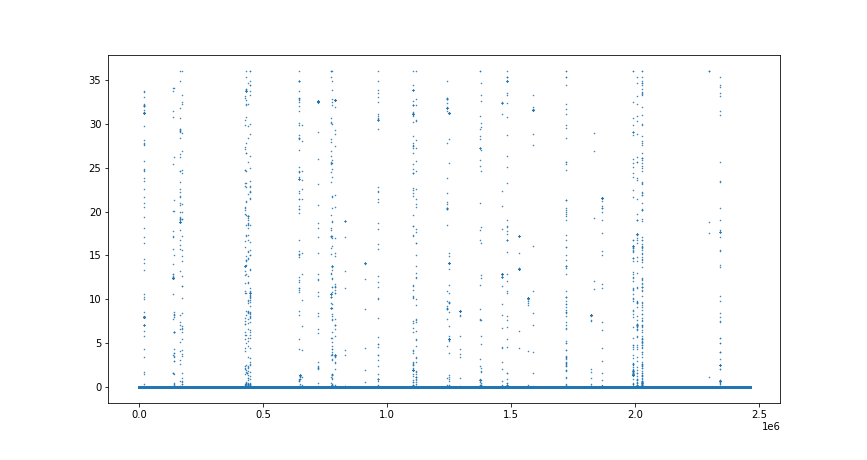

<ipython-input-46-7e7d0c165190>:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(-np.log(1-pf[1,:]),'.', markersize=1)


In [46]:
%matplotlib notebook
plt.figure(figsize=(14,5))
plt.plot(-np.log(1-pf[1,:]),'.', markersize=1)
# plt.ylim(-100,50)

(2461208, 3)

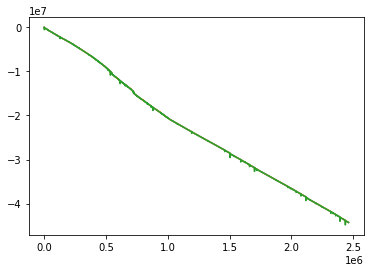

In [71]:
plt.plot(GC.hmm.alpha.T)
# plt.plot(GC.hmm.beta.T)

<IPython.core.display.Javascript object>


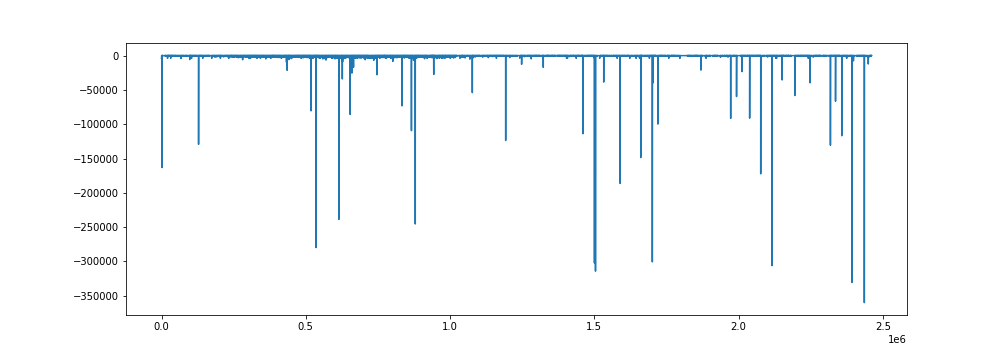

In [115]:
plt.figure(figsize=(14,5))
plt.plot(LLv[:,1]-LLv[:,0], markersize=1)
plt.plot(np.where(np.isfinite(LLv[:,1]-LLv[:,0]),np.nan,1),'*')

plt.plot(np.where(np.isfinite(LLv[:,0]),np.nan,20000),'*')
plt.plot(np.where(np.isfinite(LLv[:,1]),np.nan,10000),'*')

In [119]:
_,_,total_npoints = GC.all_mu_and_cov()

In [125]:
 np.log(total_npoints)

15.409253546923276

In [122]:
_,_,total_npoints = GC.all_mu_and_cov()
LLv_reg = np.maximum((np.max(LLv,axis=1) - np.log(total_npoints))[:,np.newaxis],LLv)

<IPython.core.display.Javascript object>


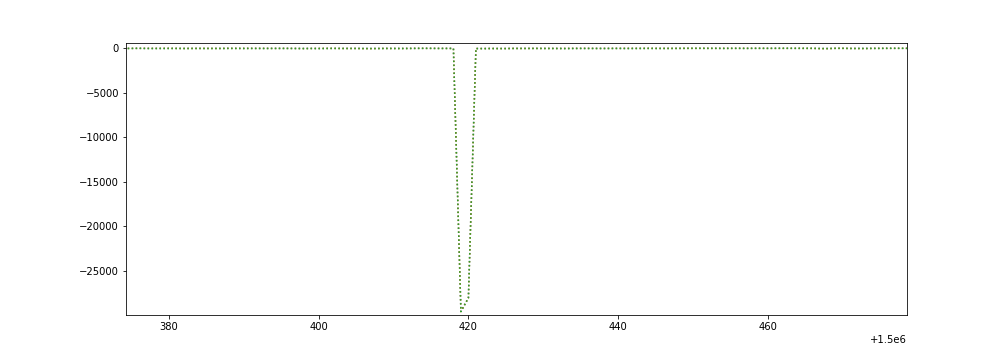

In [129]:
plt.figure(figsize=(14,5))
# plt.plot(LLv, linewidth=.5)
plt.plot(LLv_reg,':')
# plt.ylim(-1000,1000)

In [27]:
print(GC.hmm.A)
print(GC.hmm.phi)

[[9.99997562e-01 2.43796794e-06]
 [4.22535211e-02 9.57746479e-01]]
[[ -247.60718107  -247.51882057  -247.83037244 ...   -12.64143888
    -13.13367215   -60.14581098]
 [-4102.65662991 -4157.71035082 -4092.1385822  ...   -21.2091908
    -20.00942799   -33.10859413]]


In [28]:
GC.hmm.alpha.dtype

dtype('float64')

(-1000.0, 1000.0)

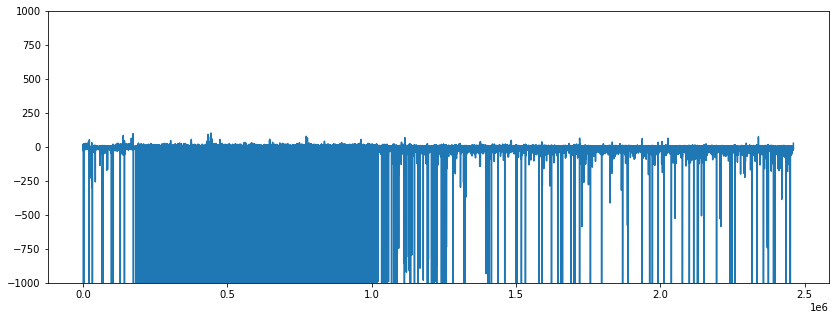

In [29]:
plt.figure(figsize=(14,5))
plt.plot(LLv[:,1]-LLv[:,0], markersize=1)
plt.ylim(-1000,1000)

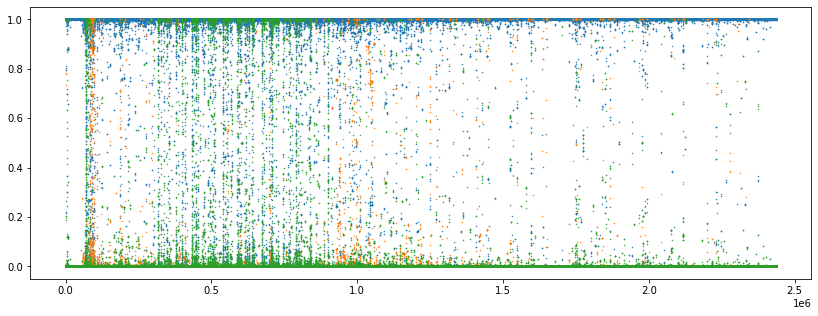

In [21]:
plt.figure(figsize=(14,5))
plt.plot(pf.T,'.', markersize=1)

<ipython-input-20-1aa7656eef08>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(pf.T)-np.log(np.maximum(1-pf.T,1e-12)),'.', markersize=1)


(-100.0, 50.0)

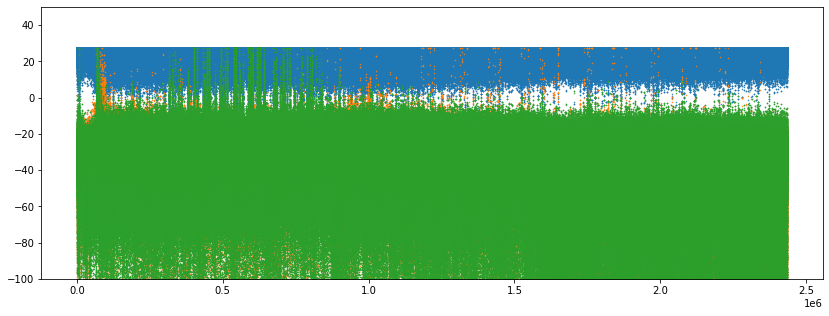

In [20]:
plt.figure(figsize=(14,5))
plt.plot(np.log(pf.T)-np.log(np.maximum(1-pf.T,1e-12)),'.', markersize=1)
plt.ylim(-100,50)

In [32]:
np.log(np.maximum(1-pf.T,1e-12))

array([[-2.76310211e+01,  0.00000000e+00],
       [-2.76310211e+01,  0.00000000e+00],
       [-2.76310211e+01,  0.00000000e+00],
       ...,
       [-1.55306545e+01, -1.79937837e-07],
       [-6.91973280e+00, -9.88582414e-04],
       [-7.42040096e-07, -1.41138629e+01]])

In [152]:
project.current_animal.annotations.labels

['seizure', 'repeated IIEDs', '(auto)seizure']

In [153]:
len(project.current_animal.annotations.annotations_list)

102

In [17]:
project.project_file[:-7]

'/media/mfpleite/LaCie_1/ML_pyecog_2/AwesomeProject_IIEDs'

In [18]:
project.save_to_json(fname = project.project_file[:-7]+'_test.pyecog')

In [149]:
# f_vec_d = np.hstack([f_vec, np.vstack([np.zeros(f_vec.shape[1]), np.diff(f_vec, axis=0)])])
LL = GC.log_likelyhoods(f_vec,bias=True,no_scale=False)

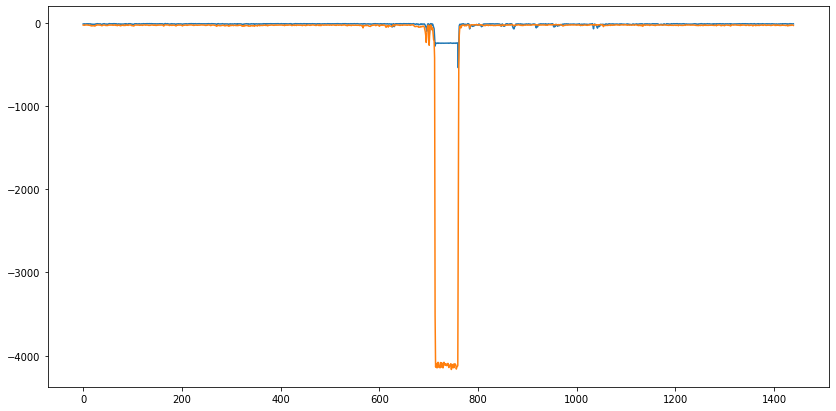

In [150]:
plt.figure(figsize=(14,7))
plt.plot(LL)

In [620]:
print(np.linalg.det(blanks_cov),np.linalg.det(GC.class_cov[0]))

0.000582672948028742 0.28223231073679556


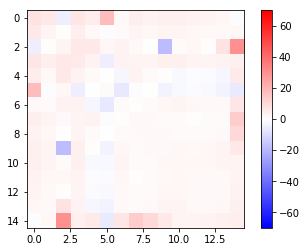

In [621]:
plt.imshow(GC.class_cov[0]/blanks_cov,cmap='bwr',vmin=-70,vmax=70)
plt.colorbar()

In [622]:
@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [623]:
p = LL2prob(LL)

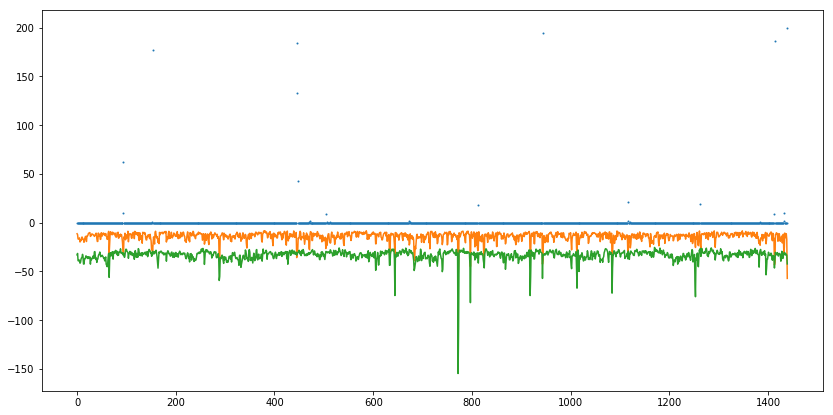

In [624]:
plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(LL[:,0])
# plt.plot(b_LLr)
plt.plot(LL[:,1])
# plt.plot(s_LLr)
# plt.vlines(starts[1:],-1000,0,linestyles=':')
# plt.vlines(ends[1:],-1000,0,linestyles=':')
# plt.xlim(400,1000)/

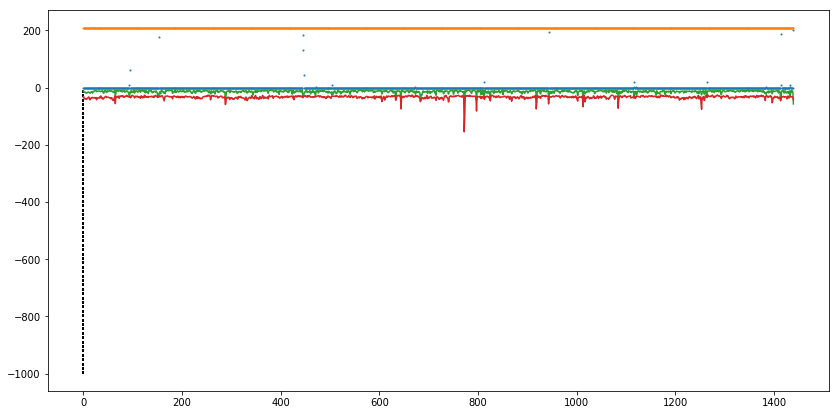

In [625]:
plt.figure(figsize=(14,7))
plt.plot(p[:,1]*200,'.',markersize=2)
plt.plot(p[:,2]*200+210,'.',markersize=2)
plt.plot(LL[:,0])
# plt.plot(b_LLr)
plt.plot(LL[:,1])
# plt.plot(s_LLr)
plt.vlines(starts[1:],-1000,0,linestyles=':')
plt.vlines(ends[1:],-1000,0,linestyles=':')
# plt.xlim(400,1000)/

In [699]:
LLv = []
R2v = []
drawplots = False

project.current_animal.eeg_files.sort()
for eegfname in project.current_animal.eeg_files:
    fname = '.'.join(eegfname.split('.')[:-1]+['features'])
    f_vec = np.fromfile(fname,dtype='float64')
    f_vec = f_vec.reshape((-1,fe.number_of_features))
#     f_vec = np.hstack([f_vec, np.vstack([np.zeros(f_vec.shape[1]), np.diff(f_vec, axis=0)])])
    LL = GC.log_likelyhoods(f_vec,bias=False,no_scale=False)
    R2 = GC.log_likelyhoods(f_vec,bias=False,no_scale=True)
    LLv.append(LL)
    R2v.append(R2)
    p  = LL2prob(LL) 
    if drawplots:
        plt.figure(figsize=(14,7))
        plt.plot(p[:,1]*200,'.',markersize=2)
        plt.plot(LL[:,0],'.',markersize=2)
        plt.plot(LL[:,1],'.',markersize=2)
        plt.vlines(starts[1:],-1000,0,linestyles=':')
        plt.vlines(ends[1:],-1000,0,linestyles=':')
        plt.title(eegfname)
        plt.show()
    # plt.xlim(400,1000)

    
LLv = np.vstack(LLv)
R2v = np.vstack(R2v)
pv  = LL2prob(LLv) 

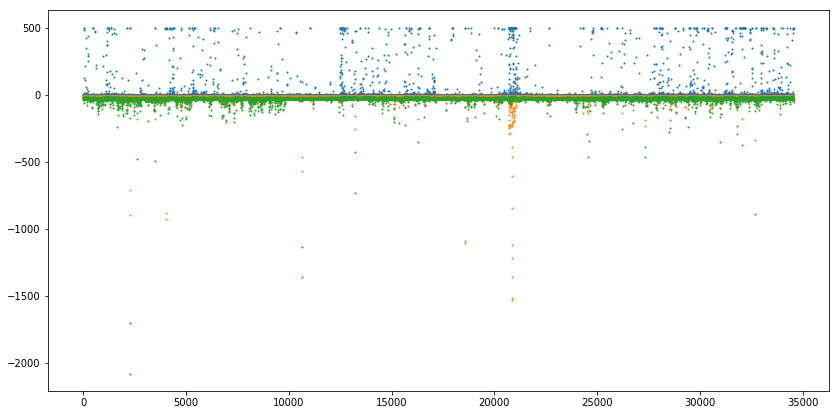

In [700]:
plt.figure(figsize=(14,7))
plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot(LLv[:,0],'.',markersize=2)
plt.plot(LLv[:,1],'.',markersize=2)
# plt.vlines(starts[1:],-1000,0,linestyles=':')
# plt.vlines(ends[1:],-1000,0,linestyles=':')

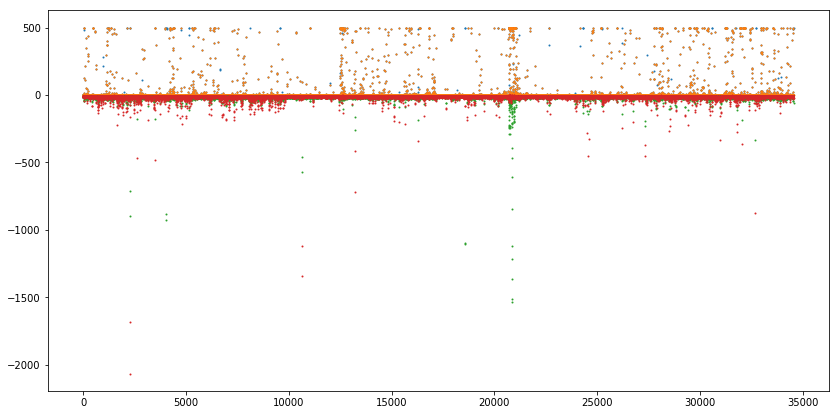

In [701]:
th = stats.chi2.isf(1e-3,15,scale=0.5)
plt.figure(figsize=(14,7))


plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot((pv[:,1]*(-R2v[:,1]<th))*500,'.',markersize=2)
# plt.plot((-R2v[:,1]<th)*500,'-',markersize=2)
plt.plot(R2v[:,0],'.',markersize=2)
plt.plot(R2v[:,1],'.',markersize=2)

In [645]:
@jit(nopython=True)
def LL2prob_jit(LL,prob):
    for i in range(LL.shape[0]):
        v = np.exp(LL[i,:])
        prob[i,:] = v / np.sum(v)
        
def LL2prob(LL):
    prob = np.zeros(LL.shape)
    LL2prob_jit(LL,prob)
    return prob

In [646]:
import hmm_pyecog
importlib.reload(hmm_pyecog)

<module 'hmm_pyecog' from '../hmm_pyecog.py'>

In [647]:
# HMM = hmm_pyecog.HMM_LL()
HMM = GC.hmm

In [649]:
HMM.A

array([[9.99956519e-01, 4.34807815e-05, 0.00000000e+00],
       [4.83870968e-02, 9.51612903e-01, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [702]:
p  = LL2prob(LLv).T
pf = HMM.forward_backward(LLv.T)
starts = np.diff(((pf[1,:].T*(-R2v[:,1]<th)))>.5)>0
ends =  np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))<0

../hmm_pyecog.py:245: RuntimeWarning: divide by zero encountered in log
  alpha[:, 0] = log_phi[:, 0] + np.log(stationary_dist)
../hmm_pyecog.py:249: RuntimeWarning: divide by zero encountered in log
  alpha_t = log_phi[:, t] + np.log(np.dot(exp_alpha_t.T, A))  # sure no undeflow here...
../hmm_pyecog.py:284: RuntimeWarning: divide by zero encountered in log
  beta[:, t] = np.log(beta_t) + max_beta_t


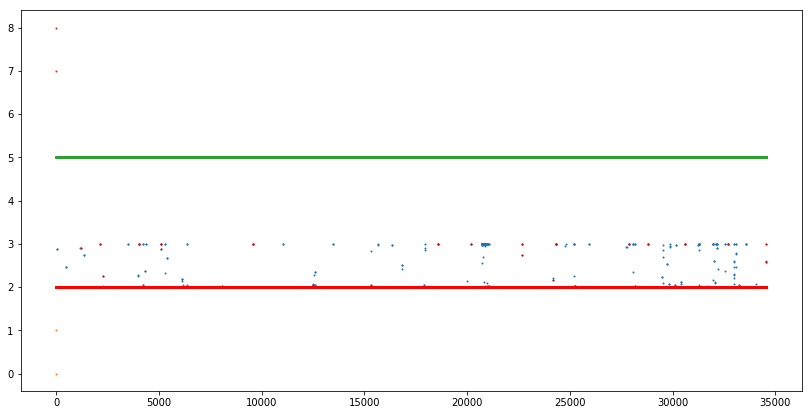

In [753]:
plt.figure(figsize=(14,7))
plt.plot(pf[1,:].T+2,'.',markersize=2)
plt.plot((pf[1,:].T*(-R2v[:,1]>th))+2,'r.',markersize=2)
plt.plot(p[1,:].T,'.',markersize=2)
plt.plot(pf[2,:].T+5,'.',markersize=2)
plt.plot(p[2,:].T+7,'.',markersize=2)
# plt.plot(p[1,:].T-pf[1,:].T-2,'.',markersize=2)

th = stats.chi2.isf(1e-3,15,scale=0.5)
# plt.xlim(20000,22050)

In [754]:
np.sum(np.diff((pf[1,:]>.5).astype('int')>0))


123

In [755]:
starts = np.nonzero(np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))>0)[0]
ends =   np.nonzero(np.diff(((pf[1,:].T*(-R2v[:,1]<th))>.5).astype('int'))<0)[0]

In [756]:
len(starts)

55

In [757]:
np.tile(np.eye(10),(5,1,1)).shape

(5, 10, 10)

(20600, 21500)

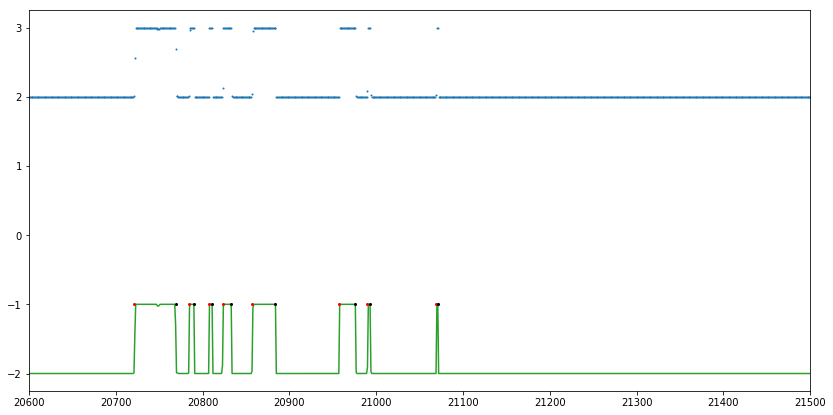

In [759]:
r = (20600,21500)

plt.figure(figsize=(14,7))
plt.plot(pf[1,:].T+2,'.',markersize=2)
plt.plot(p[1,:].T,'.',markersize=2)
# plt.plot(p[1,:].T-pf[1,:].T-2,'.',markersize=2)

th = stats.chi2.isf(1e-3,15,scale=0.5)
plt.plot((pf[1,:].T*(-R2v[:,1]<th))-2,'-',markersize=2)
plt.plot(starts,starts*0-1,'o',markersize=2,color='r')
plt.plot(ends,ends*0-1,'o',markersize=2,color='k')
plt.xlim(*r)

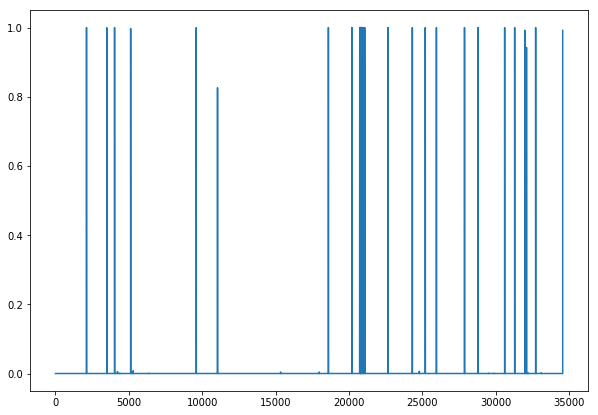

In [125]:
plt.figure(figsize=(10,7))
plt.plot(pf[1,:])
plt.show()

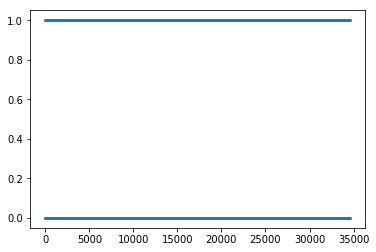

In [126]:
th = stats.chi2.isf(1e-1,15,scale=0.5)
plt.plot((-R2v[:,1]<th),'.',markersize=2)

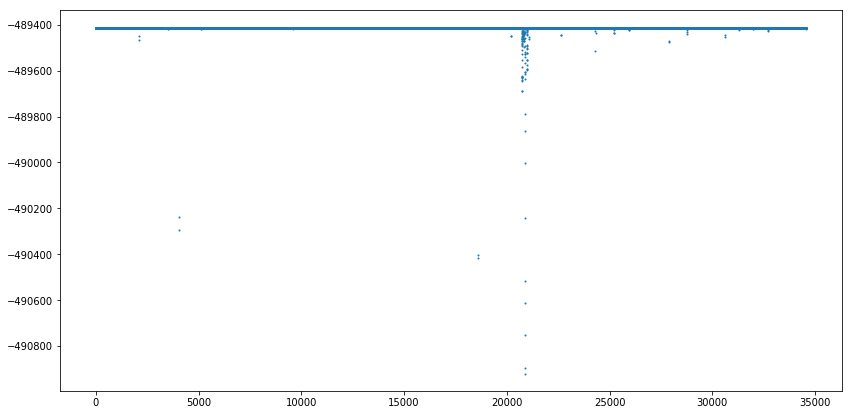

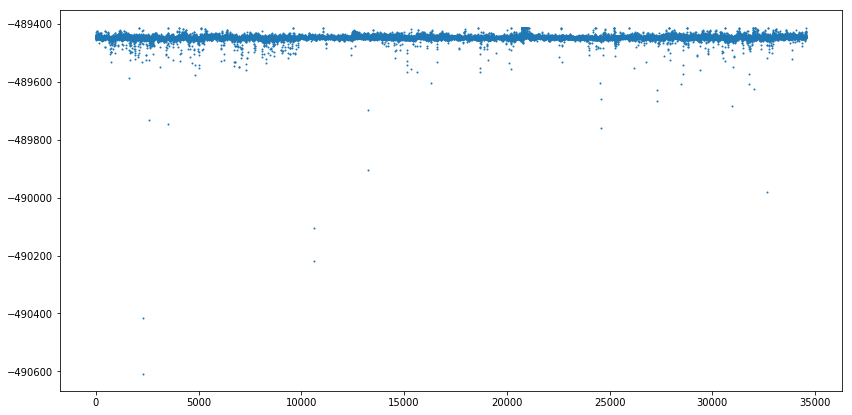

In [127]:

plt.figure(figsize=(14,7))
plt.plot((HMM.alpha[0,:] + HMM.beta[0,:]).T,'.',markersize=2)
plt.figure(figsize=(14,7))
plt.plot((HMM.alpha[1,:] + HMM.beta[1,:]).T,'.',markersize=2)

(20000, 22000)

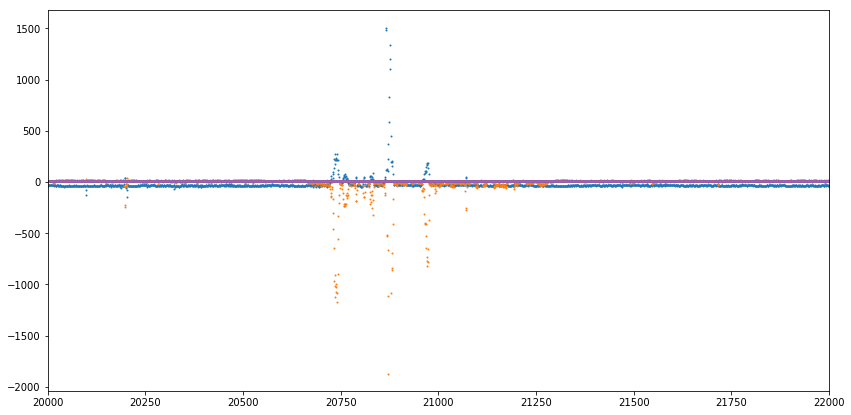

In [128]:
plt.figure(figsize=(14,7))
plt.plot(np.diff(HMM.beta.T+HMM.alpha.T,axis=1),'.',markersize=2)

plt.plot(HMM.posterior.T+10,'.',markersize=2)
plt.xlim(20000,22000)

/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/mfpleite/anaconda3/envs/pyecog2_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


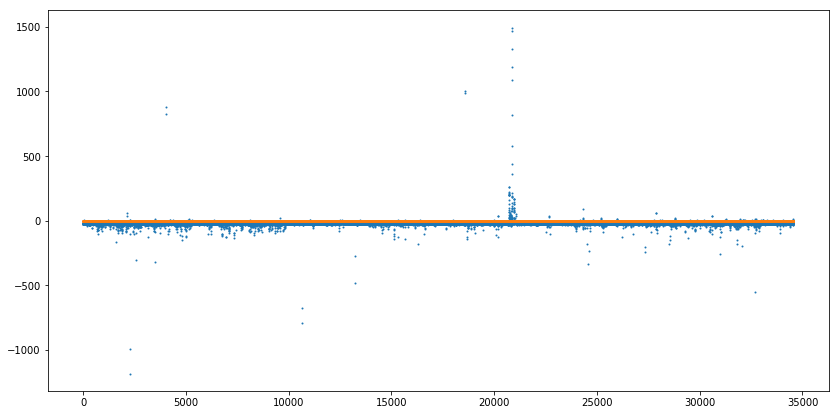

In [129]:
plt.figure(figsize=(14,7))
# plt.plot(pv[:,1]*500,'.',markersize=2)
plt.plot(LLv[:,1] - LLv[:,0],'.',markersize=2)
plt.plot(np.exp(LLv[:,1] - LLv[:,0])/np.exp(LLv[:,1] - LLv[:,0]),'.',markersize=2)
# plt.plot(LLv[:,1],'.',markersize=2)
# plt.plot(HMM.phi.T,'.',markersize=2)
# plt.xlim(20000,22000)

In [130]:
LLf =(HMM.alpha+HMM.beta).T

In [131]:
dLLf = np.diff(LLf,axis=1)
dLLv = np.diff(LLv,axis=1)

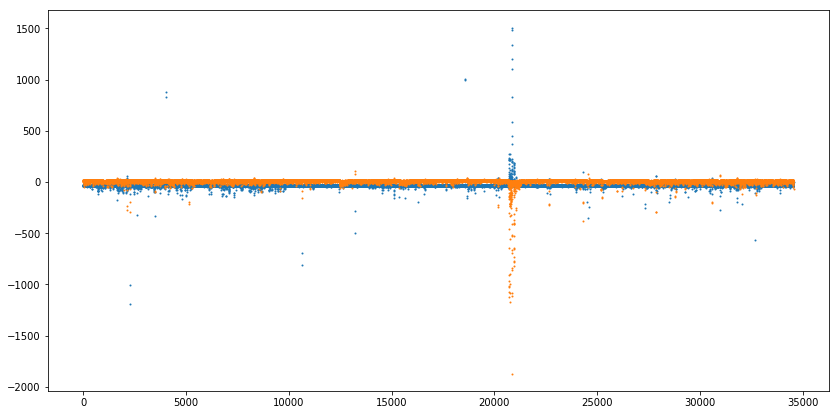

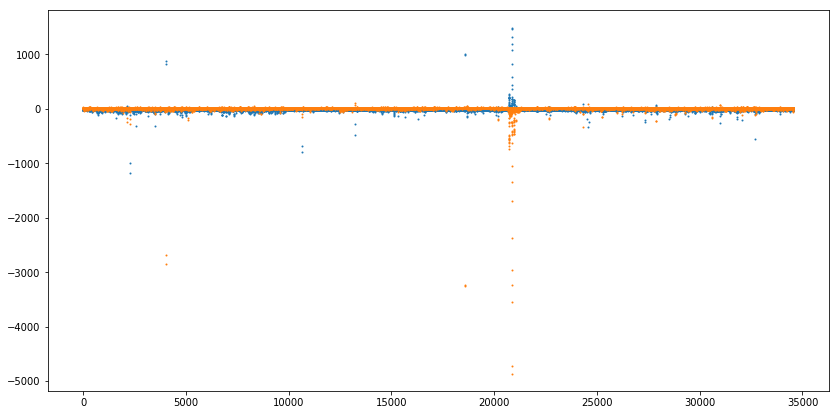

In [132]:
plt.figure(figsize=(14,7))
plt.plot(dLLf,'.',markersize=2)
plt.figure(figsize=(14,7))
plt.plot(dLLv,'.',markersize=2)

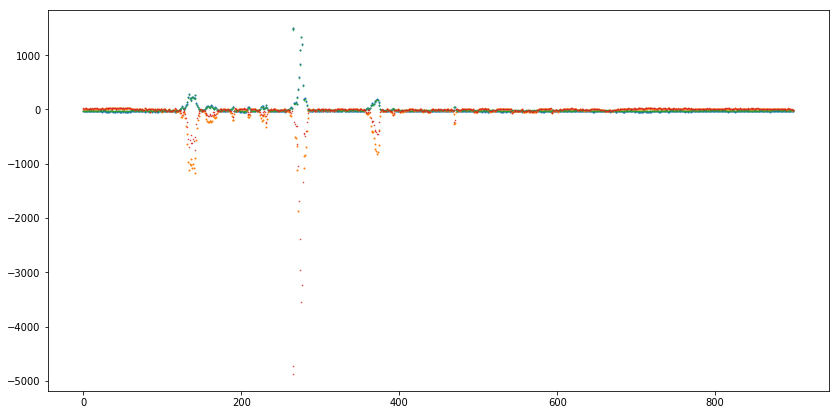

In [133]:
r = range(20600,21500)
plt.figure(figsize=(14,7))
plt.plot(dLLf[r],'.',markersize=2)
plt.plot(dLLv[r],'.',markersize=1)


In [405]:
a = {'b':[[1,2],[6,7]],
     'c':[[2,3],[8,9]]
    }
keys = ['b','c']

In [412]:
d = [(l[0],l[1],i+1) for i,key in enumerate(keys) for l in a[key]]
d

[(1, 2, 1), (6, 7, 1), (2, 3, 2), (8, 9, 2)]

In [413]:
d.sort()
d

[(1, 2, 1), (2, 3, 2), (6, 7, 1), (8, 9, 2)]

In [481]:
dt=.5
def transitions2matrix(t,dt,n):
    A = np.zeros((n+1,n+1))
    A[0,d[0][2]] +=1
    for i in range(len(t)-1):
        if t[i][1] >= t[i+1][0]-dt: # transitions between labled events
            A[t[i][2],t[i+1][2]] +=1
        else:  # transitions between labled events and blanks
            A[t[i][2],0]   +=1
            A[0,t[i+1][2]] += 1
    return A

def tansitions2rates(B,nblankpoints,nclasspoints):
    A = B
    A[0,0] = nblankpoints - np.sum(A[0,:])
    A[0,:] /= np.sum(A[0,:])
    for i in range(len(nclasspoints)):
        if nclasspoints[i]:
            A[i+1,i+1] = nclasspoints[i] - np.sum(A[i+1,:])
            A[i+1,:] /= np.sum(A[i+1,:])
        else: # For classes that do not occur, default to transition to blanks
            A[i+1,:] = 0
            A[i+1,0] = 1
    return A

In [482]:
A = np.zeros((3,3),dtype='float64')
A = transitions2matrix(d,.5,3)

In [483]:
B  = tansitions2rates(A,100,[10,5,0])

In [484]:
B

array([[0.97, 0.02, 0.01, 0.  ],
       [0.1 , 0.8 , 0.1 , 0.  ],
       [0.2 , 0.  , 0.8 , 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

In [661]:
tv = []
for i in range(10):
    t =np.arange(100)
    tv.append(t)
tvs = np.hstack(tv)

In [662]:
tvs.shape

(1000,)

In [3]:
6//10

0

In [4]:
1.58496687e+09

1584966870.0

In [5]:
1572565228.494363 + 3600

1572568828.494363

In [198]:
any([False, True, False])

True

In [79]:
def intervals_overlap(a,b):
    return (a[0] <= b[0] < a[1]) or (a[0] <= b[1] < a[1]) or (b[0] <= a[0] < b[1]) or (b[0] <= a[1] < b[1])



In [80]:
manual_label_positions = [[0,.5],[3,4],[7,8]]

In [83]:
if not any([intervals_overlap([.1,2],pos) for pos in manual_label_positions]):
    print('do it')
else:
    print('skip it')


skip it
